<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/master/Transformer/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
collab = False
if collab:
    !pip install tensorflow-gpu --quiet
    !git clone https://github.com/mizzmir/NLP.git

In [2]:
import os
import sys
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

if collab:
  sys.path.insert(0, r"./NLP/utilities")
  data_dir = "./NLP/data"
else:
  sys.path.insert(0, r"../utilities")
  data_dir = "../data"

from utils import *
from model import *
from TransformerTrainer import *
from model import *

tf.get_logger().setLevel('WARNING')

In [3]:
data = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
print("input shape ", data.shape)
padding_mask = makePaddingMask(data)

encoder = Encoder(embedding_size=10,
                  max_sentence_len=1000,
                  vocab_size=3000,
                  blocks_amount=3,
                  heads_number=5, 
                  dff=2048)
encoder_out  = encoder(data, mask=padding_mask)
print(encoder_out.shape)

input shape  (64, 62)
(64, 62, 10)


In [4]:
input_data = np.ones((64, 26))
mask = makeSequenceMask(input_data.shape[1])
print("Decoder input shape ", input_data.shape)
blocks_amount = 2
heads = 5
en_vocab_size = 100
fr_vocab_size = 200
decoder = Decoder(embedding_size=10,
                  max_sentence_len=1000,
                  vocab_size=100,
                  blocks_amount=3,
                  heads_number=5, 
                  dff=2048)
"""
decoder masks are :
- encoder_padding_mask - padding mask made on encoder input data
- decoder sequences mask - sequence mask made on decoder input data
"""
decoder_out  = decoder(encoder_out, input_data, pad_mask=None, elements_mask=None)
print("decoder_out ", decoder_out.shape)

Decoder input shape  (64, 26)
decoder_out  (64, 26, 10)


In [5]:
transformer_model = Transformer(embedding_size=512,
                                dff=2048,
                                input_max_seq_length=2000,
                                output_max_seq_length=1855,
                                input_vocab_size=4980,
                                output_vocab_size=7001,
                                encoder_blocks=4,
                                decoder_blocks=2,
                                heads=8)

# input_data and output_data
input_data = tf.random.uniform((64, 52), dtype=tf.int64, minval=0, maxval=100)
output_data = tf.random.uniform((64, 29), dtype=tf.int64, minval=0, maxval=250)

encoder_pad_mask = makePaddingMask(input_data)
elements_mask = makeSequenceMask(output_data.shape[1])
print("output_data ", output_data.shape)
print("elements_mask ", elements_mask.shape)
transformer_output = transformer_model(input_data, output_data, encoder_pad_mask, elements_mask)
print(transformer_output.shape)

output_data  (64, 29)
elements_mask  (29, 29)
(64, 29, 7001)


In [6]:
BATCH_SIZE = 64
EPOCHS = 10
num_layers = 4 # 6
d_model = 128 # 512
dff = 512  # 2048
num_heads = 8 

In [7]:
data_dir = "../data"
en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))

#data = read_data(os.path.join(data_dir, "fra-eng"), "fra.txt")

#en_lines, fr_lines = list(zip(*data))
en_lines, fr_lines = shuffle(en_lines, fr_lines)

#en_lines = en_lines[:40000]
#fr_lines = fr_lines[:40000]

en_lines = [normalize(line) for line in en_lines]
fr_lines = [normalize(line) for line in fr_lines]

en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

en_lines = en_test
fr_lines = fr_test

reading data from  ../data/small_vocab_en
reading data from  ../data/small_vocab_fr


In [8]:
# creating tokenizers
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en for en in en_train), target_vocab_size=2**13)

fr_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (fr for fr in fr_train), target_vocab_size=2**13)

print("en_tokenizer size ", en_tokenizer.vocab_size)
print("fr_tokenizer size ", fr_tokenizer.vocab_size)

en_tokenizer size  542
fr_tokenizer size  712


In [9]:
# train dataset
fr_train_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_train]
fr_train_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_train]

fr_train_in = pad_sequences(fr_train_in, padding='post')
fr_train_out = pad_sequences(fr_train_out, padding='post')

# test dataset
fr_test_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_test]
fr_test_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_test]

fr_test_in = pad_sequences(fr_test_in, padding='post')
fr_test_out = pad_sequences(fr_test_out, padding='post')

en_train = [en_tokenizer.encode(line) for line in en_train]
en_test = [en_tokenizer.encode(line) for line in en_test]

en_train = pad_sequences(en_train, padding='post')
en_test = pad_sequences(en_test, padding='post')

In [10]:
trainer = TransformerTrainer(batch_size=BATCH_SIZE,
                             num_layers=num_layers, 
                             d_model=d_model,
                             dff=dff,
                             num_heads=num_heads,
                             tokenizers=[en_tokenizer, fr_tokenizer],
                             predict_every=5)

In [11]:
losses, accuracy= trainer.train(train_data=[en_train, fr_train_in, fr_train_out],
                                test_data=[en_test, fr_test_in, fr_test_out],
                                prediction_data=[en_lines, fr_lines],
                                epochs=10)

Number of devices: 4
creating dataset...
prediction input :  the peach is my most loved fruit but the strawberry is her most loved . 
prediction output:  la peche est mon fruit le plus aime mais la fraise elle est le plus aime . 
training from scratch


Epoch 1 training Loss 57.6746 Accuracy 0.2024  test Loss 19.8654 Accuracy 0.4234
Saving checkpoint for epoch 0: ./checkpoints/train/ckpt-1
Epoch 2 training Loss 11.5500 Accuracy 0.4896  test Loss 2.4672 Accuracy 0.6056
Epoch 3 training Loss 1.8342 Accuracy 0.5893  test Loss 0.7828 Accuracy 0.6233
Epoch 4 training Loss 0.8517 Accuracy 0.5988  test Loss 0.4839 Accuracy 0.6274
Epoch 5 training Loss 0.6162 Accuracy 0.6015  test Loss 0.3897 Accuracy 0.6283
Epoch 6 training Loss 0.5153 Accuracy 0.6027  test Loss 0.3431 Accuracy 0.6296
----------------------------PREDICTION----------------------------
Predicted : la peche est mon fruit le plus aime mais la fraise elle est le plus aime . 
Correct   : la peche est mon fruit le plus aime mais la fraise elle est le plus aime . 
--------------------------END PREDICTION--------------------------
Saving checkpoint for epoch 5: ./checkpoints/train/ckpt-2
Epoch 7 training Loss 0.4657 Accuracy 0.6034  test Loss 0.3383 Accuracy 0.6298
Epoch 8 training L

In [12]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

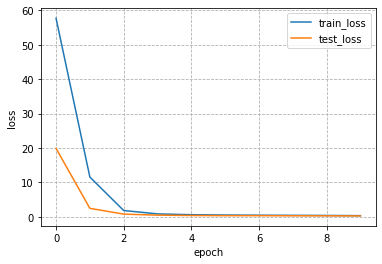

In [13]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")

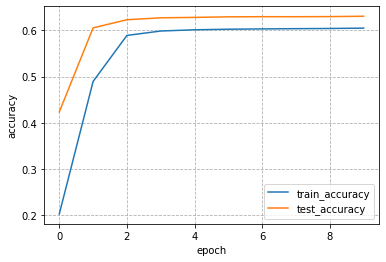

In [14]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")

In [15]:
transformer_model = trainer.transformer_model
checkpoint_path = trainer.checkpoint_path

loadWeights(transformer_model, checkpoint_path)

Latest checkpoint restored!!


In [16]:
trainer.translate("What are you doing?")

'mes animaux les plus redoutes sont des souris . '